# Performance of MetFrag and SIRIUS on the MassBank Data

For the performance evaluation, we are looking at the case where performance when only tandem mass-spectrometry (MS2) information is used.

In [48]:
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

from matchms import Spectrum

from ssvm.data_structures import CandSQLiteDB_Massbank
from ssvm.evaluation_tools import get_topk_performance_csifingerid

In [49]:
DB_FN = "../db/massbank__only_normalized_scores.sqlite"
DB_URI = "file:" + DB_FN + "?mode=ro"
DB_CONN_RO = sqlite3.connect(DB_URI, uri=True)

In [51]:
molecule_identifier = "inchikey1"
cands = CandSQLiteDB_Massbank(db_fn=DB_FN, molecule_identifier=molecule_identifier)

res = []

for idx, (ds, ) in enumerate(DB_CONN_RO.execute("SELECT distinct(dataset) FROM scored_spectra_meta")): 
    d_mf = {}
    d_sir = {}
        
    for jdx, (acc, mol) in enumerate(DB_CONN_RO.execute(
        "SELECT accession, %s FROM scored_spectra_meta " \
        "   INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule " \
        "   INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset " \
        "   WHERE dataset IS ? AND retention_time >= 3 * column_dead_time_min" 
        % molecule_identifier,
        (ds, )
    )): 
        d_mf[jdx] = {}
        d_sir[jdx] = {}
        
        spec = Spectrum(np.array([]), np.array([]), metadata={"spectrum_id": acc, "molecule_identifier": mol})
        
        # Get the label-space for the spectrum
        _lab_space = cands.get_labelspace(spec)
        d_mf[jdx]["n_cand"] = len(_lab_space)
        d_sir[jdx]["n_cand"] = len(_lab_space)
        
        # Find the correct structure on the label-space
        _index_of_correct_structure = _lab_space.index(mol)
        d_mf[jdx]["index_of_correct_structure"] = _index_of_correct_structure
        d_sir[jdx]["index_of_correct_structure"] = _index_of_correct_structure
        
        # Get the MS2 scores
        d_mf[jdx]["score"] = cands.get_ms2_scores(spec, "metfrag__norm", scale_scores_to_range=False, return_as_ndarray=True)
        d_sir[jdx]["score"] = cands.get_ms2_scores(spec, "sirius__sd__correct_mf__norm", scale_scores_to_range=False, return_as_ndarray=True)
    
    _n_cand_med = np.median([d_mf[i]["n_cand"] for i in range(jdx)])
    _topk_mf = get_topk_performance_csifingerid(d_mf)
    _topk_sir = get_topk_performance_csifingerid(d_sir)
    
    print(ds)
    print(_n_cand_med)
    print(np.round(_topk_mf[1][[0, 4, 9, 19]], 1))
    print(np.round(_topk_sir[1][[0, 4, 9, 19]], 1))
    
    # MetFrag
    res.append(
        [
            "MetFrag",                  # MS2-scorer
            ds,                         # dataset
            len(d_mf),                  # number of examples
            _n_cand_med                 # median number of candidates
        ] + _topk_mf[0].tolist()[:50],  # topk MetFrag
    )
    
    # SIRIUS
    res.append(
        [
            "SIRIUS",                    # MS2-scorer
            ds,                          # dataset
            len(d_mf),                   # number of examples
            _n_cand_med                  # median number of candidates
        ] + _topk_sir[0].tolist()[:50],  # topk MetFrag
    )

AC_003
320.0
[12.8 32.3 40.2 45.3]
[26.8 55.  61.2 62.6]
AU_003
1319.0
[ 3.8 16.2 32.2 40.7]
[39.4 66.7 73.3 77.8]
AU_002
1009.0
[ 4.4 20.8 31.7 41.2]
[41.8 64.5 72.1 77.5]
AU_001
800.0
[ 2.8 18.2 31.3 42.4]
[37. 72. 76. 78.]
BML_001
1037.0
[ 2.5 12.3 19.  28. ]
[30.8 65.6 72.  77.2]
CE_001
836.5
[ 2.1  6.9 16.7 25.2]
[52.6 74.4 82.1 94.9]
EA_003
1313.0
[ 5.8 29.  43.6 56.9]
[55.  80.8 85.  89.9]
EA_002
1381.0
[ 3.7 21.2 36.8 46.2]
[38.9 64.8 72.8 79.7]
EQ_006
1046.5
[ 6.7 26.3 33.3 44.1]
[48.8 71.1 77.7 83.9]
EQ_004
862.5
[ 7.6 28.5 42.6 53. ]
[43.4 69.1 77.9 81.8]
ET_002
5037.0
[ 5.8 19.9 26.4 32.6]
[48. 78. 84. 88.]
KW_000
2006.5
[ 0.1  6.7 14.  21. ]
[23.6 45.5 54.5 60.6]
LU_001
989.5
[ 7.5 28.8 40.3 50.5]
[34.  59.8 67.9 74. ]
NA_003
1104.5
[ 4.6 19.2 27.1 37.7]
[38.1 66.  76.3 78.4]
PR_002
226.5
[ 7.7 20.1 30.2 39.9]
[33.4 65.3 76.4 83. ]
RP_001
658.0
[ 5.2 17.  27.9 34.7]
[55.  80.7 90.  93.3]
SM_001
800.0
[ 2.8 20.  33.5 46.2]
[44.1 74.4 80.4 85.2]
UF_003
1412.0
[ 2.5 16.7 27.4

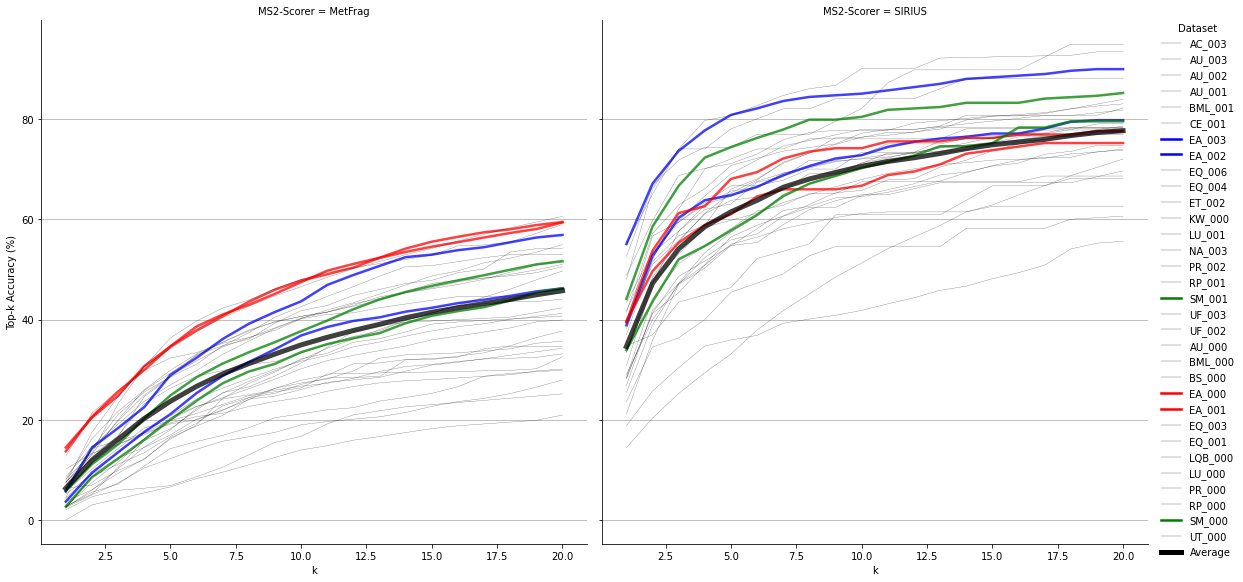

In [52]:
_columns = ["MS2-Scorer", "Dataset", "Number of Examples", "Median number of Candidates"]
_columns_k = [k + 1 for k in range(50)]
res_df = pd.DataFrame(res, columns=_columns + _columns_k).melt(id_vars=_columns, value_vars=_columns_k, value_name="topk", var_name="k")
res_df = res_df.assign(topk_acc=(res_df["topk"] / res_df["Number of Examples"] * 100))

res_df_avg = res_df \
    .groupby(["MS2-Scorer", "k"])[["Dataset", "Number of Examples", "topk"]] \
    .aggregate({"Dataset": lambda _: "Average", "Number of Examples": np.sum, "topk": np.sum}) \
    .reset_index()
res_df_avg = res_df_avg.assign(topk_acc=(res_df_avg["topk"] / res_df_avg["Number of Examples"] * 100))
res_df_avg = pd.concat((res_df, res_df_avg), axis=0)

_palette = {ds: "black" for _, ds, *_ in res}
_palette["Average"] = "black"
_palette["EA_000"] = "red"
_palette["EA_001"] = "red"
_palette["EA_002"] = "blue"
_palette["EA_003"] = "blue"
_palette["SM_000"] = "green"
_palette["SM_001"] = "green"

_sizes = {ds: 0.25 for _, ds, *_ in res}
_sizes["Average"] = 5
_sizes["EA_000"] = 2.5
_sizes["EA_001"] = 2.5
_sizes["EA_002"] = 2.5
_sizes["EA_003"] = 2.5
_sizes["SM_000"] = 2.5
_sizes["SM_001"] = 2.5

g = sns.relplot(
    data=res_df_avg[res_df_avg["k"] <= 20], 
    x="k", y="topk_acc", 
    size="Dataset", sizes=_sizes,
    hue="Dataset", palette=_palette,
    col="MS2-Scorer",
    legend="brief",
    kind="line",
    height=8,
    alpha=0.75
)
g.axes[0, 0].grid(axis="y")
g.axes[0, 1].grid(axis="y")
g.set_ylabels("Top-k Accuracy (%)")

In [ ]:
g = sns.catplot(data=res_df[res_df["k"].isin([1, 5, 10, 20])], x="Dataset", y="topk_acc", row="MS2-Scorer", col="k", kind="bar", sharey="col")
for c in range(4):
    ax = g.axes[1, c] 
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)